## Import Libraries

In [1]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import seaborn as sns
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, Dense, Conv2D, TimeDistributed, Flatten, GRU, Dropout, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [4]:
# Enable memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Enable mixed precision
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


### Convert Raw video datasets into a 320x240 at 30fps

In [3]:
def downgrade_video_quality(input_folder, output_folder, target_width=320, target_height=240, target_fps=30):
    """
    Downgrades the quality of videos in a given folder and organizes them by exercise name.

    Args:
        input_folder: The path to the folder containing the raw videos.
        output_folder: The path to the folder where the downgraded videos will be saved.
        target_width: The desired width of the output videos.
        target_height: The desired height of the output videos.
        target_fps:  The desired frames per second.  Crucially, get from the original.
    """

    # Create the output folder and subfolders if they don't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for exercise_name in os.listdir(input_folder):
        exercise_path = os.path.join(input_folder, exercise_name)

        # Check if it's a directory (to avoid processing non-directory files)
        if os.path.isdir(exercise_path):
            output_exercise_path = os.path.join(output_folder, exercise_name)
            if not os.path.exists(output_exercise_path):
                os.makedirs(output_exercise_path)

            for filename in os.listdir(exercise_path):
                if filename.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):  # Add more extensions if needed
                    input_filepath = os.path.join(exercise_path, filename)
                    output_filepath = os.path.join(output_exercise_path, filename)

                    try:
                        # Open the video file
                        video_capture = cv2.VideoCapture(input_filepath)

                        # Check if video opened successfully
                        if not video_capture.isOpened():
                            print(f"Error: Could not open video {input_filepath}")
                            continue

                        # Get original video properties
                        original_fps = video_capture.get(cv2.CAP_PROP_FPS)
                        # original_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)) #Not used
                        # original_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT)) #Not used
                        
                        # Use the original FPS if target_fps is not specified or is invalid
                        fps_to_use = original_fps if original_fps > 0 else target_fps

                        # Define the codec and create VideoWriter object
                        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'XVID' for AVI, or other codecs as needed
                        out = cv2.VideoWriter(output_filepath, fourcc, fps_to_use, (target_width, target_height))


                        while True:
                            ret, frame = video_capture.read()
                            if not ret:
                                break  # End of video

                            # Resize the frame
                            resized_frame = cv2.resize(frame, (target_width, target_height))

                            # Write the resized frame to the output video
                            out.write(resized_frame)

                        # Release resources
                        video_capture.release()
                        out.release()
                        print(f"Processed: {input_filepath} -> {output_filepath}")

                    except Exception as e:
                        print(f"Error processing {input_filepath}: {e}")

    print("Video processing complete.")



if __name__ == '__main__':
    raw_folder = "raw2"  # Replace with the actual path to your raw videos folder
    downgraded_folder = "downgraded_raw2"  # The output folder

    downgrade_video_quality(raw_folder, downgraded_folder)

Processed: raw2\LumbarSideBends\13631965-3410-4313-9a12-faa683b44961.mp4 -> downgraded_raw2\LumbarSideBends\13631965-3410-4313-9a12-faa683b44961.mp4
Processed: raw2\LumbarSideBends\20250205_053352000_iOS.MOV -> downgraded_raw2\LumbarSideBends\20250205_053352000_iOS.MOV
Processed: raw2\LumbarSideBends\20250205_053735000_iOS.MOV -> downgraded_raw2\LumbarSideBends\20250205_053735000_iOS.MOV
Processed: raw2\LumbarSideBends\20250206_063412000_iOS.MOV -> downgraded_raw2\LumbarSideBends\20250206_063412000_iOS.MOV
Processed: raw2\LumbarSideBends\475555509_9263473073698401_6919277742428364951_n.mp4 -> downgraded_raw2\LumbarSideBends\475555509_9263473073698401_6919277742428364951_n.mp4
Processed: raw2\LumbarSideBends\475871883_9236836983060007_880998261948400557_n (1).mp4 -> downgraded_raw2\LumbarSideBends\475871883_9236836983060007_880998261948400557_n (1).mp4
Processed: raw2\LumbarSideBends\475874828_9483337038357444_2782041067290051443_n (1).mp4 -> downgraded_raw2\LumbarSideBends\475874828_94

### Set Numpy, Python, and TF seeds

In [2]:
spatial_input_size = (224,224,3)
temporal_input_size = (320, 240, 1)
seed_constant = 7
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

batch_size = 8 # Change this shit pag sasabog na yung GPU

## Visualize Data for 1st CNN stream


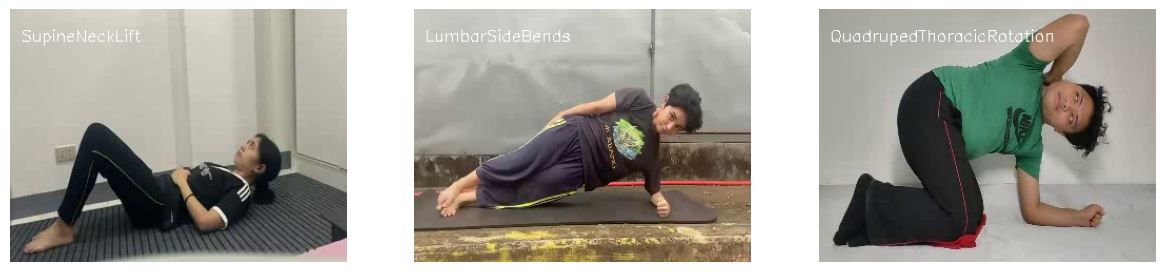

In [8]:
plt.figure(figsize = (20,20))

all_class_names = os.listdir('downgraded_raw2')

random_range = random.sample(range(len(all_class_names)), 3)

for counter, random_index in enumerate(random_range, 1):
    selected_class_name = all_class_names[random_index]

    video_files_names_list = os.listdir(f'downgraded_raw2/{selected_class_name}') 
    selected_video_file_name =  random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'downgraded_raw2/{selected_class_name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()
    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255),1)

    plt.subplot(5,4, counter);plt.imshow(rgb_frame);plt.axis('off')


## PreProcess the Dataset

In [9]:
IMAGE_HEIGHT, IMAGE_WIDTH =  96, 96 #for rgb/1st stream

SEQUENCE_LENGTH = 30

DATASET_DIR = r"D:\MAPUA\CNN_GRU_usingRGBOF\downgraded_raw2"

CLASSES_LIST = ['LumbarSideBends','QuadrupedThoracicRotation','SupineNeckLift']

## Extraction of Features 

1st Stream

In [10]:
def frames_extraction_RGB(video_path):
    """Extract frames from video and return normalized RGB frames"""
    frames_list1 = []
    
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)
    
    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the position of the next frame to read
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        
        success, frame = video_reader.read()
        if not success:
            break
        
        # Convert BGR (default in OpenCV) to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Resize to target dimensions and normalize to [0, 1]
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame / 255.0
        
        frames_list1.append(normalized_frame)
    
    video_reader.release()
    
    # Determine a padding frame if fewer than SEQUENCE_LENGTH frames were extracted
    if frames_list1:
        pad_frame = np.zeros_like(frames_list1[0])
    else:
        pad_frame = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.float32)
    
    # Pad the list to ensure the length is SEQUENCE_LENGTH
    while len(frames_list1) < SEQUENCE_LENGTH:
        frames_list1.append(pad_frame)
    
    return frames_list1


2nd CNN Stream

###### Get optical flow frames

In [11]:
def compute_optical_flow(prev_frame, next_frame):
    """
    Compute optical flow using the Lucas-Kanade method between two frames.
    
    Returns:
        good_old: Array of points from the previous frame.
        good_new: Array of corresponding points from the next frame.
    """
    # Convert frames to grayscale
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(21, 21),
                     maxLevel=3,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    # Parameters for Shi-Tomasi corner detection (good features to track)
    feature_params = dict(maxCorners=3000, qualityLevel=0.01, minDistance=0.1)
    
    # Detect features in the previous frame
    p0 = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    if p0 is None:
        return [], []

    # Calculate optical flow (find corresponding points in the next frame)
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, p0, None, **lk_params)

    # Ensure valid output and select good points based on the status array
    if p1 is not None and st is not None:
        st = st.flatten()
        good_old = p0[st == 1]
        good_new = p1[st == 1]
    else:
        good_old, good_new = [], []

    return good_old, good_new

def create_mei_mhi(flow, shape, tau=10):
    """
    Create Motion Energy Image (MEI) and Motion History Image (MHI) from optical flow vectors.
    
    Args:
        flow: Tuple containing (good_old, good_new) points.
        shape: Tuple defining the output image size (height, width).
        tau: Time constant for motion decay in the MHI.
        
    Returns:
        mei: The Motion Energy Image (binary representation of motion).
        mhi: The Motion History Image (captures motion intensity with decay).
    """
    # Initialize MEI and MHI as zero arrays
    mei = np.zeros(shape, dtype=np.float32)
    mhi = np.zeros(shape, dtype=np.float32)

    # Iterate over each pair of corresponding points to draw motion vectors
    for (new, old) in zip(flow[1], flow[0]):
        x1, y1 = new.ravel()
        x2, y2 = old.ravel()
        
        # Draw a line for the motion on the MEI (binary, using a fixed thickness)
        cv2.line(mei, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)
        
        # Draw the same line on the MHI (this will later be decayed over time)
        cv2.line(mhi, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)

    # Apply decay to the MHI (simulate motion fading over time)
    mhi[mhi > 0] -= 255 / tau  
    mhi[mhi < 0] = 0  # Clip negative values to 0

    return mei, mhi

def frames_extraction_OF(video_path, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH):
    """
    Extracts Motion Energy Images (MEI) from a video by computing optical flow between frame pairs.
    
    Args:
        video_path: Path to the video file.
        SEQUENCE_LENGTH: Number of frame pairs (and thus MEI images) to extract.
        IMAGE_HEIGHT: Target height for resizing frames.
        IMAGE_WIDTH: Target width for resizing frames.
    
    Returns:
        A 4D NumPy array of shape (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 1)
        containing the normalized MEI images.
    """
    frames_list2 = []

    # Open the video file
    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        print(f"Error: Could not open video {video_path}.")
        return frames_list2

    # Total frames and skip window calculation for even sampling
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate over the video using the skip window to select frame pairs
    for frame_counter in range(0, video_frames_count - skip_frames_window, skip_frames_window):
        # Read the previous frame
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)
        success, prev_frame = video_reader.read()
        if not success:
            break

        # Read the next frame
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter + skip_frames_window)
        success, next_frame = video_reader.read()
        if not success:
            break

        # Resize frames to target dimensions. Note: cv2.resize expects (width, height)
        prev_frame_resized = cv2.resize(prev_frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        next_frame_resized = cv2.resize(next_frame, (IMAGE_WIDTH, IMAGE_HEIGHT))

        # Compute optical flow between the two frames
        good_old, good_new = compute_optical_flow(prev_frame_resized, next_frame_resized)

        # If no valid optical flow vectors were found, skip this pair
        if len(good_old) == 0 or len(good_new) == 0:
            print(f"Warning: No optical flow vectors found for frames {frame_counter} and {frame_counter + skip_frames_window}.")
            continue

        # Create the Motion Energy Image (MEI) from the optical flow vectors
        mei, _ = create_mei_mhi((good_old, good_new), (IMAGE_HEIGHT, IMAGE_WIDTH), tau=10)

        # Normalize the MEI to 0-255 and convert to an 8-bit image for visualization
        mei_norm = cv2.normalize(mei, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        # Expand dimensions to add a channel axis (resulting in shape: H x W x 1)
        mei_norm = np.expand_dims(mei_norm, axis=-1)

        # Append the normalized MEI image to the list
        frames_list2.append(mei_norm)

    # Release the video capture
    video_reader.release()

    # If fewer than SEQUENCE_LENGTH frames were extracted, pad with zero-frames
    while len(frames_list2) < SEQUENCE_LENGTH:
        frames_list2.append(np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.uint8))

    # If more than SEQUENCE_LENGTH frames were collected, truncate the list
    if len(frames_list2) > SEQUENCE_LENGTH:
        frames_list2 = frames_list2[:SEQUENCE_LENGTH]

    # Convert the list of frames to a 4D NumPy array
    frames_list2 = np.stack(frames_list2, axis=0)

    return frames_list2

## Dataset Creation

1st Stream

In [13]:
def create_dataset_1st():
    """Creates the dataset for the first (RGB) stream with flipping and rotation augmentations."""
    features1 = []
    labels1 = []
    video_files_paths1 = []
    
    # Create an ImageDataGenerator with rotation and horizontal flip augmentations.
    datagen = ImageDataGenerator(
        rotation_range=15,        # Allow rotations up to 15 degrees.
        horizontal_flip=True,     # Enable horizontal flipping.
        fill_mode='nearest'       # Strategy to fill in newly created pixels.
    )
    
    # Iterate over each class in the dataset.
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of class: {class_name}')
        class_dir = os.path.join(DATASET_DIR, class_name)
        files_list = os.listdir(class_dir)
        
        # Process each video file in the current class directory.
        for file_name in files_list:
            video_file_path = os.path.join(class_dir, file_name)
            
            try:
                # Extract the original frames using the defined function.
                frames = frames_extraction_RGB(video_file_path)
                
                # Only proceed if the number of extracted frames equals SEQUENCE_LENGTH.
                if len(frames) == SEQUENCE_LENGTH:
                    # Add the original frames to the features list.
                    features1.append(frames)
                    labels1.append(class_index)
                    video_files_paths1.append(video_file_path)
                    
                    # Create an augmented version of the frames.
                    augmented_frames = []
                    # Generate a random seed that will be used for every frame in the sequence
                    # to ensure a consistent transformation across the entire video.
                    seed = np.random.randint(1000)
                    
                    for frame in frames:
                        # Expand dimensions to match the input shape expected by ImageDataGenerator.
                        frame_expanded = np.expand_dims(frame, 0)
                        it = datagen.flow(frame_expanded, batch_size=1, seed=seed)
                        # Generate the augmented frame.
                        augmented_frame = next(it)[0]
                        augmented_frames.append(augmented_frame)
                    
                    # Append the augmented frames as a separate sample.
                    features1.append(augmented_frames)
                    labels1.append(class_index)
                    video_files_paths1.append(video_file_path + '_aug')
                else:
                    print(f"Warning: {video_file_path} did not yield {SEQUENCE_LENGTH} frames.")
            
            except Exception as e:
                print(f"Warning: Processing failed for {video_file_path}: {str(e)}")
                continue
    
    # Convert lists to NumPy arrays.
    features1 = np.array(features1)
    labels1 = np.array(labels1)
    
    return features1, labels1, video_files_paths1


In [15]:
output_folder = "rgb_data"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Create your dataset for the RGB stream
features1, labels1, video_files_paths1 = create_dataset_1st()

# Display dataset information
print(f"Features shape: {features1.shape}")
print(f"Labels shape: {labels1.shape}")
print(f"Number of videos (including augmented): {len(video_files_paths1)}")

# Save the features, labels, and video paths into .npy files inside 'rgb_data'
np.save(os.path.join(output_folder, "features1.npy"), features1)
np.save(os.path.join(output_folder, "labels1.npy"), labels1)
np.save(os.path.join(output_folder, "video_files_paths1.npy"), video_files_paths1)


Extracting Data of class: LumbarSideBends
Extracting Data of class: QuadrupedThoracicRotation
Extracting Data of class: SupineNeckLift
Features shape: (294, 30, 96, 96, 3)
Labels shape: (294,)
Number of videos (including augmented): 294


In [16]:
#convert labels into one-hot encoded vectors
one_hot_encoded_labels1 = to_categorical(labels1, num_classes=len(CLASSES_LIST))

In [17]:
# Display the converted labels
unique_labels1, counts1 = np.unique(labels1, return_counts=True)
for label, count in zip(unique_labels1, counts1):
    print(f"Label {label}: {count} instances")

Label 0: 100 instances
Label 1: 100 instances
Label 2: 94 instances


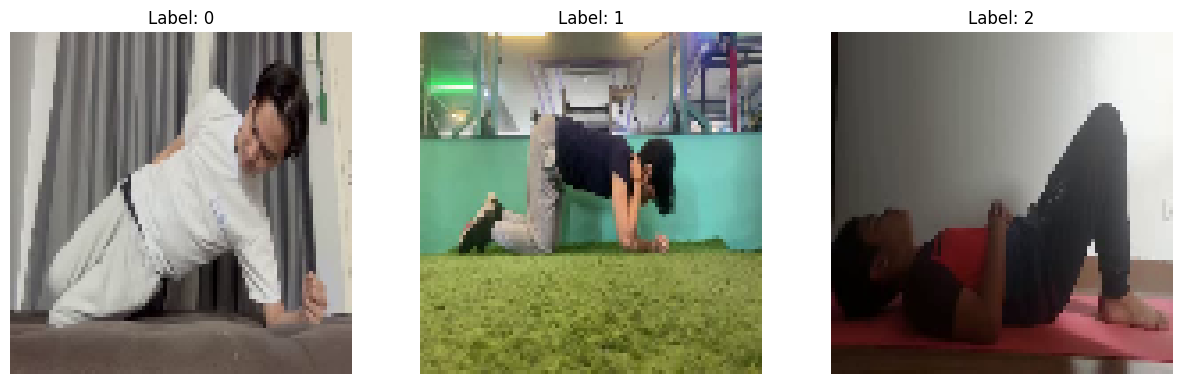

In [18]:
plt.figure(figsize=(15, 5))

for i, label in enumerate(unique_labels1):
    # Find the first index of the current label
    index = np.where(labels1 == label)[0][0]

#Extract the corresponding video frames
    frames = features1[index]

#Select a random frame instead of the middle one
    random_frame = frames[np.random.randint(0, len(frames))]

#Plot the frame
    plt.subplot(1, 3, i + 1)
    plt.imshow(random_frame)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

Show Sample Augmeted Frames

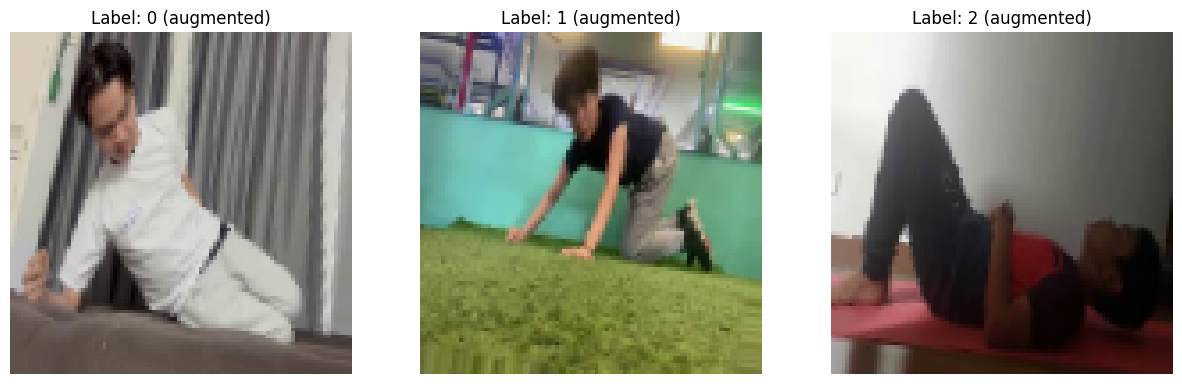

In [19]:
plt.figure(figsize=(15, 5))

# Get unique labels (assumes labels1 is a NumPy array)
unique_labels = np.unique(labels1)

for i, label in enumerate(unique_labels):
    # Find all indices where the sample has the current label and is an augmented sample.
    # We check if '_aug' is in the corresponding file path.
    augmented_indices = [
        j for j, (lab, path) in enumerate(zip(labels1, video_files_paths1))
        if lab == label and '_aug' in path
    ]
    
    # If no augmented sample is found, use the first original sample.
    if len(augmented_indices) == 0:
        print(f"No augmented sample found for label {label}. Using original sample.")
        index = np.where(labels1 == label)[0][0]
    else:
        index = augmented_indices[0]
    
    # Extract the video frames for the chosen sample.
    frames = features1[index]
    
    # Select a random frame from the sequence.
    random_frame = frames[np.random.randint(0, len(frames))]
    
    # Plot the frame.
    plt.subplot(1, len(unique_labels), i + 1)
    plt.imshow(random_frame)
    plt.title(f"Label: {label} (augmented)")
    plt.axis('off')

plt.show()


2nd Stream

In [21]:
def create_dataset_2nd():
    """Creates the dataset with only flipping and rotation augmentations for the optical flow stream."""
    features2 = []
    labels2 = []
    video_files_paths2 = []
    
    # Create an ImageDataGenerator for applying rotation and horizontal flip augmentations.
    datagen = ImageDataGenerator(
        rotation_range=15,        # Rotate images up to 15 degrees.
        horizontal_flip=True,     # Apply horizontal flipping.
        fill_mode='nearest'       # Define how to fill pixels when transformations create new empty areas.
    )
    
    # Loop over each class directory
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of class: {class_name}')
        class_dir = os.path.join(DATASET_DIR, class_name)
        files_list = os.listdir(class_dir)
        
        for file_name in files_list:
            video_file_path = os.path.join(class_dir, file_name)
            
            try:
                # Extract the optical flow frames using the frames_extraction_OF function.
                # Note: The parameters (SEQUENCE_LENGTH, 320, 240) specify the number of frames and the target dimensions.
                frames = frames_extraction_OF(video_file_path, SEQUENCE_LENGTH, 320, 240)
                
                if len(frames) == SEQUENCE_LENGTH:
                    # Save the original optical flow frames.
                    features2.append(frames)
                    labels2.append(class_index)
                    video_files_paths2.append(video_file_path)
                    
                    # Create an augmented version of the optical flow frames.
                    augmented_frames = []
                    seed = np.random.randint(1000)  # Use the same seed for all frames to maintain consistency across the sequence.
                    
                    for frame in frames:
                        frame_expanded = np.expand_dims(frame, 0)
                        it = datagen.flow(frame_expanded, batch_size=1, seed=seed)
                        augmented_frame = next(it)[0]
                        augmented_frames.append(augmented_frame)
                    
                    # Append the augmented sample.
                    features2.append(augmented_frames)
                    labels2.append(class_index)
                    video_files_paths2.append(video_file_path + '_aug')
            
            except Exception as e:
                print(f"Warning: Processing failed for {video_file_path}: {str(e)}")
                continue
    
    # Convert the collected lists to NumPy arrays.
    features2 = np.array(features2)
    labels2 = np.array(labels2)
    
    return features2, labels2, video_files_paths2


In [22]:
# Create the folder 'opticalflow_data' if it doesn't already exist
output_folder = "opticalflow_data"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Create your dataset for the optical flow stream
features2, labels2, video_files_paths2 = create_dataset_2nd()

# Display dataset information
print(f"Features shape: {features2.shape}")
print(f"Labels shape: {labels2.shape}")
print(f"Number of videos (including augmented): {len(video_files_paths2)}")

# Save the features, labels, and video paths into .npy files inside 'opticalflow_data'
np.save(os.path.join(output_folder, "features2.npy"), features2)
np.save(os.path.join(output_folder, "labels2.npy"), labels2)
np.save(os.path.join(output_folder, "video_files_paths2.npy"), video_files_paths2)

Extracting Data of class: LumbarSideBends
Extracting Data of class: QuadrupedThoracicRotation
Extracting Data of class: SupineNeckLift
Features shape: (294, 30, 320, 240, 1)
Labels shape: (294,)
Number of videos (including augmented): 294


In [23]:
#convert labels into one-hot encoded vectors
one_hot_encoded_labels2 = to_categorical(labels2,num_classes=len(CLASSES_LIST))

In [24]:
# Display the converted labels 
unique_labels2, counts2 = np.unique(labels2, return_counts=True)
for label, count in zip(unique_labels2, counts2):
    print(f"Label {label}: {count} instances")

Label 0: 100 instances
Label 1: 100 instances
Label 2: 94 instances


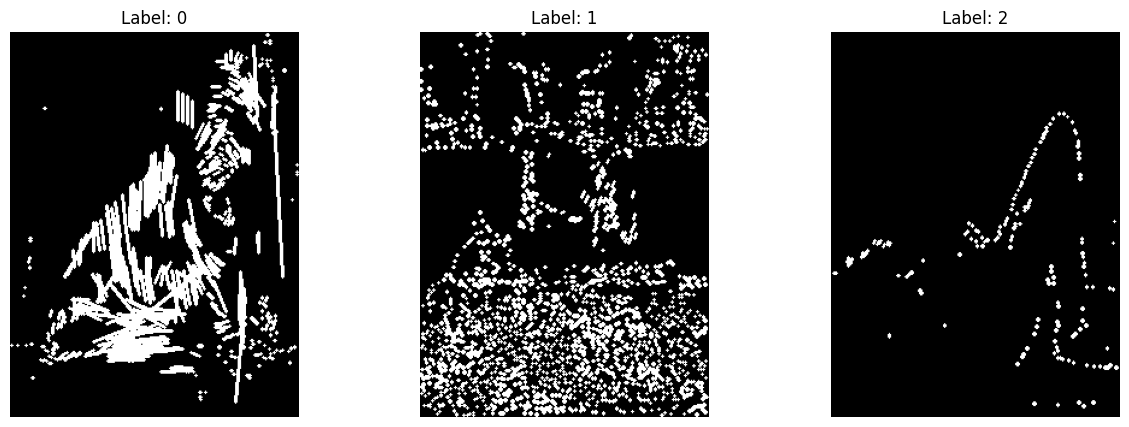

In [25]:
plt.figure(figsize=(15, 5))

for i, label in enumerate(unique_labels2):
    # Find the first index of the current label
    index = np.where(labels2 == label)[0][0]

#Extract the corresponding video frames
    frames = features2[index]

#Select a random frame instead of the middle one
    random_frame = frames[np.random.randint(0, len(frames))]

#Plot the frame
    plt.subplot(1, 3, i + 1)
    plt.imshow(random_frame, cmap="grey")
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

Show Sample Augmented Frames:

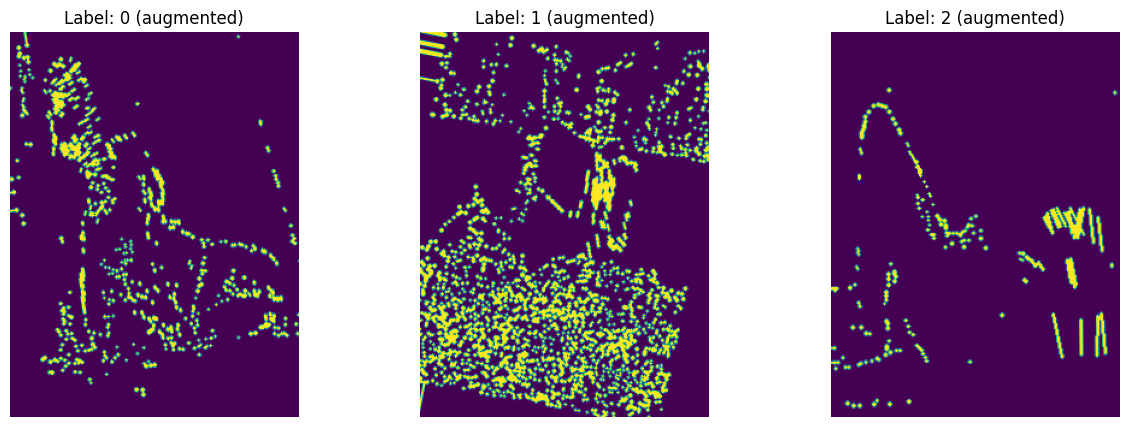

In [29]:
plt.figure(figsize=(15, 5))

# Get unique labels (assumes labels1 is a NumPy array)
unique_labels = np.unique(labels2)

for i, label in enumerate(unique_labels):
    # Find all indices where the sample has the current label and is an augmented sample.
    # We check if '_aug' is in the corresponding file path.
    augmented_indices = [
        j for j, (lab, path) in enumerate(zip(labels2, video_files_paths2))
        if lab == label and '_aug' in path
    ]
    
    # If no augmented sample is found, use the first original sample.
    if len(augmented_indices) == 0:
        print(f"No augmented sample found for label {label}. Using original sample.")
        index = np.where(labels1 == label)[0][0]
    else:
        index = augmented_indices[0]
    
    # Extract the video frames for the chosen sample.
    frames = features2[index]
    
    # Select a random frame from the sequence.
    random_frame = frames[np.random.randint(0, len(frames))]
    
    # Plot the frame.
    plt.subplot(1, len(unique_labels), i + 1)
    plt.imshow(random_frame)
    plt.title(f"Label: {label} (augmented)")
    plt.axis('off')

plt.show()


## Split Data into Train, Test, and Validation

For 1st Stream (RBG Data)

In [30]:
features_train1, features_test1, labels_train1, labels_test1 = train_test_split(features1, one_hot_encoded_labels1,
                                                                                test_size=0.20, shuffle = True, 
                                                                                random_state = seed_constant)
features_train1, features_val1, labels_train1, labels_val1 = train_test_split(
    features_train1, labels_train1, test_size=0.20, shuffle=True, random_state=seed_constant
)
output_folder = "rgb_data"
# Save the features arrays to the rgb_data folder.
np.save(os.path.join(output_folder, "features_train1.npy"), features_train1)
np.save(os.path.join(output_folder, "features_val1.npy"), features_val1)
np.save(os.path.join(output_folder, "features_test1.npy"), features_test1)

# Optionally, save the corresponding labels as well.
np.save(os.path.join(output_folder, "labels_train1.npy"), labels_train1)
np.save(os.path.join(output_folder, "labels_val1.npy"), labels_val1)
np.save(os.path.join(output_folder, "labels_test1.npy"), labels_test1)

# Display the number of samples in each set
print(f"Number of training samples: {len(features_train1)}")
print(f"Number of validation samples: {len(features_val1)}")
print(f"Number of testing samples: {len(features_test1)}")


Number of training samples: 188
Number of validation samples: 47
Number of testing samples: 59


For 2nd Stream (OF Data)

In [31]:
features_train2, features_test2, labels_train2, labels_test2 = train_test_split(features2, one_hot_encoded_labels2,
                                                                                test_size=0.20, shuffle = True, 
                                                                                random_state = seed_constant)
features_train2, features_val2, labels_train2, labels_val2 = train_test_split(
    features_train2, labels_train2, test_size=0.20, shuffle=True, random_state=seed_constant
)
output_folder = "opticalflow_data"
# Save the features arrays to the rgb_data folder.
np.save(os.path.join(output_folder, "features_train2.npy"), features_train2)
np.save(os.path.join(output_folder, "features_val2.npy"), features_val2)
np.save(os.path.join(output_folder, "features_test2.npy"), features_test2)

# Optionally, save the corresponding labels as well.
np.save(os.path.join(output_folder, "labels_train2.npy"), labels_train2)
np.save(os.path.join(output_folder, "labels_val2.npy"), labels_val2)
np.save(os.path.join(output_folder, "labels_test2.npy"), labels_test2)

# Display the number of samples in each set
print(f"Number of training samples: {len(features_train2)}")
print(f"Number of validation samples: {len(features_val2)}")
print(f"Number of testing samples: {len(features_test2)}")

Number of training samples: 188
Number of validation samples: 47
Number of testing samples: 59


## Implement 2stream Model

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Input, TimeDistributed, GlobalAveragePooling2D, Bidirectional, GRU, Dropout,SpatialDropout2D, Dense, Conv2D, MaxPooling2D, Concatenate, Dense, Dropout, Lambda
from tensorflow.keras.models import Model

In [39]:
# Define input shapes
rgb_input_shape = (features1.shape[1:])  # (Time steps, Height, Width, Channels)
of_input_shape = (features2.shape[1:])   # (Time steps, Height, Width, OF Channels)
num_classes = 3 # Example: 10 action classes

print(rgb_input_shape)
print(of_input_shape)

(30, 96, 96, 3)
(30, 320, 240, 1)


Define the RGB CNN Architecture

In [57]:
def create_rgb_stream_model(seq_length=30, input_shape=(96, 96, 3),
                            gru_units=64, dropout_rate=0.5, feature_dim=64):
    base_cnn = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                 include_top=False,
                                                 weights='imagenet')
    
    base_cnn.trainable = False

    rgb_input = Input(shape=(seq_length,) + input_shape, name="rgb_input")

    x = TimeDistributed(base_cnn, name="time_distributed_cnn")(rgb_input)
    x = TimeDistributed(GlobalAveragePooling2D(), name="time_distributed_gap")(x)
    x = GRU(gru_units, return_sequences=False, name="gru_layer")(x)
    x = Dropout(dropout_rate, name="gru_dropout")(x)
    
    output = Dense(feature_dim, activation='relu', name="rgb_feature_vector")(x)
    model = Model(inputs=rgb_input, outputs=output, name="RGB_Stream_Model")
    return model

In [58]:
# Create the RGB model
rgb_model = create_rgb_stream_model()
rgb_model.summary()

Model: "RGB_Stream_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rgb_input (InputLayer)      [(None, 30, 96, 96, 3)]   0         
                                                                 
 time_distributed_cnn (TimeD  (None, 30, 3, 3, 1280)   2257984   
 istributed)                                                     
                                                                 
 time_distributed_gap (TimeD  (None, 30, 1280)         0         
 istributed)                                                     
                                                                 
 gru_layer (GRU)             (None, 64)                258432    
                                                                 
 gru_dropout (Dropout)       (None, 64)                0         
                                                                 
 rgb_feature_vector (Dense)  (None, 64)           

Define the Optical Flow CNN architecture

In [103]:
def create_optical_flow_stream_model(seq_length=30, input_shape=(320, 240, 1),
                                     gru_units=64, dropout_rate=0.5, feature_dim=64):
    
    flow_input = Input(shape=(seq_length, ) + input_shape, name="flow_input")
    
    # Build a shallow CNN architecture for each frame.
    x = TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'),
                        name="td_conv1")(flow_input)
    x = TimeDistributed(MaxPooling2D((2, 2)), name="td_pool1")(x)
    
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'),
                        name="td_conv2")(x)
    x = TimeDistributed(MaxPooling2D((2, 2)), name="td_pool2")(x)
    
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'),
                        name="td_conv3")(x)
    x = TimeDistributed(MaxPooling2D((2, 2)), name="td_pool3")(x)

    x = TimeDistributed(GlobalAveragePooling2D(), name="td_gap")(x)
    

    x = GRU(gru_units, return_sequences=False, name="gru_flow")(x)
    x = Dropout(dropout_rate, name="gru_flow_dropout")(x)
    
    output = Dense(feature_dim, activation='relu', name="flow_feature_vector")(x)
    
    model = Model(inputs=flow_input, outputs=output, name="OpticalFlow_Stream_Model")
    return model

In [104]:
optical_flow_model = create_optical_flow_stream_model()  # Corrected call
optical_flow_model.summary()

Model: "OpticalFlow_Stream_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flow_input (InputLayer)     [(None, 30, 320, 240, 1)  0         
                             ]                                   
                                                                 
 td_conv1 (TimeDistributed)  (None, 30, 320, 240, 16)  160       
                                                                 
 td_pool1 (TimeDistributed)  (None, 30, 160, 120, 16)  0         
                                                                 
 td_conv2 (TimeDistributed)  (None, 30, 160, 120, 32)  4640      
                                                                 
 td_pool2 (TimeDistributed)  (None, 30, 80, 60, 32)    0         
                                                                 
 td_conv3 (TimeDistributed)  (None, 30, 80, 60, 64)    18496     
                                          

In [ ]:
def create_late_fusion_model(rgb_model, flow_model, num_classes, 
                                      fusion_dropout=0.5, dense_units=128):
    """
    Creates an improved late fusion model that combines the feature outputs from the 
    RGB stream and the Optical Flow stream models.
    """
    
    # Get the inputs from each branch.
    rgb_input = rgb_model.input
    flow_input = flow_model.input
    
    # Extract the feature outputs from each stream.
    rgb_features = rgb_model.output 
    flow_features = flow_model.output 
    
    # Apply Batch Normalization to each modality's features.
    rgb_features = BatchNormalization(name="rgb_bn")(rgb_features)
    flow_features = BatchNormalization(name="flow_bn")(flow_features)
    
    # Fuse the features using concatenation.
    fused_features = Concatenate(name='fusion_concat')([rgb_features, flow_features])
    
    # First transformation block after fusion.
    x = Dropout(fusion_dropout, name='fusion_dropout_1')(fused_features)
    x = Dense(dense_units, name='fusion_dense_1')(x)
    x = BatchNormalization(name='fusion_bn_1')(x)
    x = Activation('relu', name='fusion_act_1')(x)
    
    # Second transformation block for added non-linearity.
    x = Dropout(fusion_dropout, name='fusion_dropout_2')(x)
    x = Dense(dense_units // 2, name='fusion_dense_2')(x)
    x = BatchNormalization(name='fusion_bn_2')(x)
    x = Activation('relu', name='fusion_act_2')(x)
    
    # Final classification layer.
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=[rgb_input, flow_input], outputs=outputs, name='Improved_Late_Fusion_Model')
    return model

##### Display Architecture

In [79]:
num_classes = 3
late_fusion_model = create_late_fusion_model(rgb_model, optical_flow_model, num_classes)
late_fusion_model.summary()

Model: "Improved_Late_Fusion_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 flow_input (InputLayer)        [(None, 30, 320, 24  0           []                               
                                0, 1)]                                                            
                                                                                                  
 rgb_input (InputLayer)         [(None, 30, 96, 96,  0           []                               
                                 3)]                                                              
                                                                                                  
 td_gray_to_rgb (TimeDistribute  (None, 30, 320, 240  0          ['flow_input[0][0]']             
 d)                             , 3)                                     

## Train the Model

In [65]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [39]:
# Compile the late fusion model.
late_fusion_model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Set up early stopping.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model without using ModelCheckpoint.
history = late_fusion_model.fit(
    [features_train1, features_train2],  # List of inputs for the two streams.
    labels_train1,                        # One-hot encoded labels.
    validation_data=([features_val1, features_val2], labels_val1),
    epochs=50,
    batch_size=8,
    callbacks=[early_stopping]
)

# Save the final model after training.
late_fusion_model.save('late_fusion_model_newDS.h5')

Epoch 1/50



KeyboardInterrupt



In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------------
# Load Data from the npy files
# -------------------------------

# Load RGB stream data from the "rgb_data" folder.
features_train1 = np.load('rgb_data/features_train1.npy')
labels_train1   = np.load('rgb_data/labels_train1.npy')
features_val1   = np.load('rgb_data/features_val1.npy')
labels_val1     = np.load('rgb_data/labels_val1.npy')

# Load Optical Flow stream data from the "opticalflow_data" folder.
features_train2 = np.load('opticalflow_data/features_train2.npy')
features_val2   = np.load('opticalflow_data/features_val2.npy')

# Convert features (and labels if necessary) to float32.
features_train1 = features_train1.astype(np.float32)
features_val1   = features_val1.astype(np.float32)
features_train2 = features_train2.astype(np.float32)
features_val2   = features_val2.astype(np.float32)
labels_train1   = labels_train1.astype(np.float32)
labels_val1     = labels_val1.astype(np.float32)

# Optionally, print shapes to verify they match your model's expectations.
print("features_train1 shape:", features_train1.shape)
print("features_train2 shape:", features_train2.shape)
print("labels_train1 shape:", labels_train1.shape)
print("features_val1 shape:", features_val1.shape)
print("features_val2 shape:", features_val2.shape)
print("labels_val1 shape:", labels_val1.shape)

# -------------------------------
# Compile the Late Fusion Model
# -------------------------------
late_fusion_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up early stopping to monitor validation loss.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# -------------------------------
# Train the Model
# -------------------------------
history = late_fusion_model.fit(
    [features_train1, features_train2],  # Two inputs: RGB and Optical Flow features.
    labels_train1,                        # One-hot encoded labels.
    validation_data=([features_val1, features_val2], labels_val1),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping]
)

features_train1 shape: (188, 30, 96, 96, 3)
features_train2 shape: (188, 30, 320, 240, 1)
labels_train1 shape: (188, 3)
features_val1 shape: (47, 30, 96, 96, 3)
features_val2 shape: (47, 30, 320, 240, 1)
labels_val1 shape: (47, 3)
Epoch 1/100
47/47 [==============================] - 22s 290ms/step - loss: 1.4037 - accuracy: 0.3245 - val_loss: 1.0391 - val_accuracy: 0.4681
Epoch 2/100
47/47 [==============================] - 10s 212ms/step - loss: 1.3451 - accuracy: 0.3723 - val_loss: 0.9975 - val_accuracy: 0.5957
Epoch 3/100
47/47 [==============================] - 10s 211ms/step - loss: 1.3773 - accuracy: 0.3564 - val_loss: 0.9756 - val_accuracy: 0.7021
Epoch 4/100
47/47 [==============================] - 10s 211ms/step - loss: 1.2169 - accuracy: 0.3936 - val_loss: 0.9543 - val_accuracy: 0.6383
Epoch 5/100
47/47 [==============================] - 10s 211ms/step - loss: 1.1277 - accuracy: 0.4734 - val_loss: 0.8883 - val_accuracy: 0.7660
Epoch 6/100
47/47 [==============================

## Evaluate Model

59/59 [==============================] - 7s 50ms/step - loss: 0.1437 - accuracy: 0.9661
Test Loss: 0.1437
Test Accuracy: 0.9661
59/59 [==============================] - 5s 48ms/step


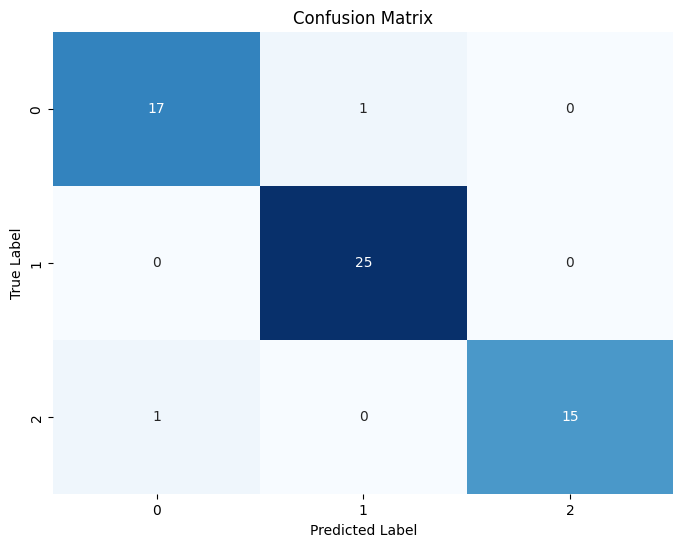

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94        18
           1       0.96      1.00      0.98        25
           2       1.00      0.94      0.97        16

    accuracy                           0.97        59
   macro avg       0.97      0.96      0.96        59
weighted avg       0.97      0.97      0.97        59



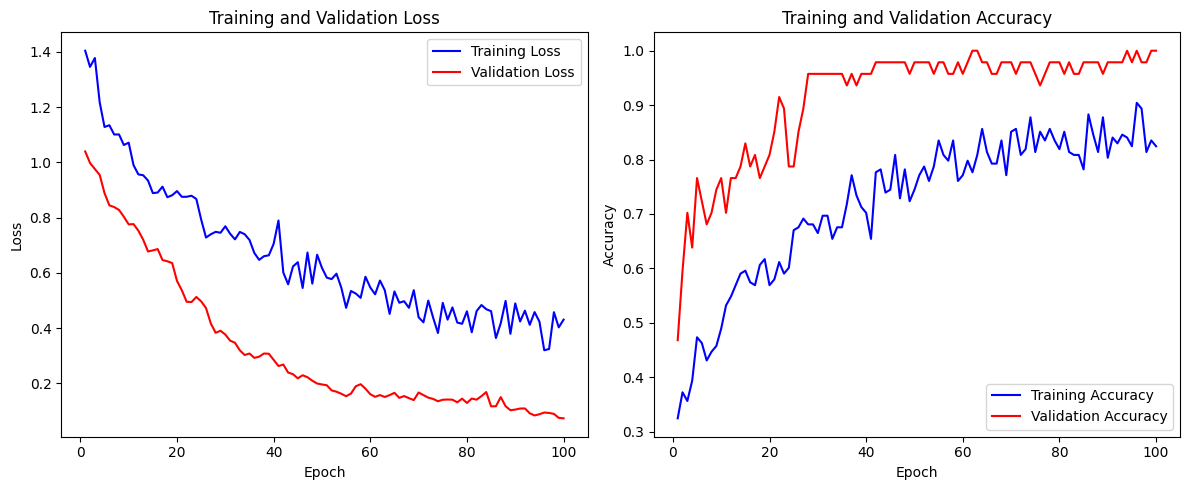

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ----------------------------
# 1. Create a tf.data.Dataset for Evaluation
# ----------------------------
# Use a very small batch size during evaluation to avoid out-of-memory errors.
batch_size_eval = 1  # Adjust this value as necessary

# Wrap the test data in a tf.data.Dataset (this keeps only one batch in memory at a time)
test_dataset = tf.data.Dataset.from_tensor_slices(((features_test1, features_test2), labels_test1))
test_dataset = test_dataset.batch(batch_size_eval).prefetch(tf.data.AUTOTUNE)

# ---------------------------- 
# 2. Evaluate the Model on the Test Set
# ----------------------------
test_loss, test_accuracy = late_fusion_model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# ----------------------------
# 3. Generate Predictions and Plot the Confusion Matrix
# ----------------------------
# Predict on the test dataset
y_pred = late_fusion_model.predict(test_dataset)

# Convert predictions from softmax output to class indices
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert true one-hot encoded labels to class indices
y_true = np.argmax(labels_test1, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report
report = classification_report(y_true, y_pred_labels)
print("Classification Report:\n", report)

# ----------------------------
# 4. Plot Training Curves (Loss and Accuracy)
# ----------------------------
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['loss'], 'b-', label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['accuracy'], 'b-', label='Training Accuracy')
plt.plot(epochs, history_dict['val_accuracy'], 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Save Model

In [ ]:
# -------------------------------
# Save the Final Model
# -------------------------------
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'CNNGRU_model_Date_Time{current_date_time_string}_Loss_{test_loss}__Accuracy_{test_accuracy}.h5'


late_fusion_model.save(model_file_name)


## Inference

In [4]:
import cv2
import numpy as np
import tensorflow as tf

# ----------------------------
# Define your class names
# ----------------------------
CLASSES_LIST = ['LumbarSideBends', 'QuadrupedThoracicRotation', 'SupineNeckLift']

# ----------------------------
# Optical Flow Functions (Lucas-Kanade)
# ----------------------------
def compute_optical_flow(prev_frame, next_frame):
    """
    Compute optical flow using the Lucas-Kanade method between two frames.
    
    Returns:
        good_old: Array of points from the previous frame.
        good_new: Array of corresponding points from the next frame.
    """
    # Convert frames to grayscale
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(21, 21),
                     maxLevel=3,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    # Parameters for Shi-Tomasi corner detection (good features to track)
    feature_params = dict(maxCorners=3000, qualityLevel=0.01, minDistance=0.1)
    
    # Detect features in the previous frame
    p0 = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    if p0 is None:
        return [], []

    # Calculate optical flow (find corresponding points in the next frame)
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, p0, None, **lk_params)

    # Ensure valid output and select good points based on the status array
    if p1 is not None and st is not None:
        st = st.flatten()
        good_old = p0[st == 1]
        good_new = p1[st == 1]
    else:
        good_old, good_new = [], []

    return good_old, good_new

def create_mei_mhi(flow, shape, tau=10):
    """
    Create Motion Energy Image (MEI) and Motion History Image (MHI) from optical flow vectors.
    
    Args:
        flow: Tuple containing (good_old, good_new) points.
        shape: Tuple defining the output image size (height, width).
        tau: Time constant for motion decay in the MHI.
        
    Returns:
        mei: The Motion Energy Image (binary representation of motion).
        mhi: The Motion History Image (captures motion intensity with decay).
    """
    # Initialize MEI and MHI as zero arrays
    mei = np.zeros(shape, dtype=np.float32)
    mhi = np.zeros(shape, dtype=np.float32)

    # Iterate over each pair of corresponding points to draw motion vectors
    for (new, old) in zip(flow[1], flow[0]):
        x1, y1 = new.ravel()
        x2, y2 = old.ravel()
        
        # Draw motion on MEI (binary)
        cv2.line(mei, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)
        
        # Draw motion on MHI (with intensity)
        cv2.line(mhi, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)

    # Decay MHI over time
    mhi[mhi > 0] -= 255 / tau  
    mhi[mhi < 0] = 0

    return mei, mhi

# ----------------------------
# Define Optical Flow Sequence Using Lucas-Kanade
# ----------------------------
def compute_optical_flow_sequence_lk(frames, target_size=(240, 320), tau=10):
    """
    For a list of frames, resize them to target_size (which is in (width, height) order),
    compute Lucas-Kanade optical flow between consecutive frames, and use create_mei_mhi
    to obtain a Motion Energy Image (MEI). The MEI is normalized to [0,1].
    
    Returns a numpy array of shape (num_frames, target_height, target_width, 1).
    """
    # First, resize frames for optical flow computation.
    # target_size is (width, height); output images will have shape (height, width).
    resized_frames = []
    for frame in frames:
        resized = cv2.resize(frame, target_size)
        resized_frames.append(resized)
    
    flow_sequence = []
    for i in range(len(resized_frames) - 1):
        prev_frame = resized_frames[i]
        next_frame = resized_frames[i + 1]
        good_old, good_new = compute_optical_flow(prev_frame, next_frame)
        if len(good_old) == 0 or len(good_new) == 0:
            # If no flow is detected, use a zero image
            mei = np.zeros((target_size[1], target_size[0]), dtype=np.float32)
        else:
            mei, _ = create_mei_mhi((good_old, good_new), (target_size[1], target_size[0]), tau=tau)
            # Normalize the MEI from 0 to 1
            mei = mei / 255.0
        # Expand dims to add the channel dimension (resulting shape: (height, width, 1))
        mei = np.expand_dims(mei, axis=-1)
        flow_sequence.append(mei.astype(np.float32))
    
    # Optical flow computed from N frames gives N-1 flow images.
    # Pad the sequence with a zero frame to match the number of frames.
    desired_length = len(frames)
    while len(flow_sequence) < desired_length:
        zero_frame = np.zeros((target_size[1], target_size[0], 1), dtype=np.float32)
        flow_sequence.append(zero_frame)
    
    return np.array(flow_sequence)

# ----------------------------
# RGB Preprocessing Function
# ----------------------------
def preprocess_rgb_frames(frames, target_size=(96, 96)):
    """
    For each frame:
      - Resize to target_size (using (width, height) order),
      - Convert from BGR to RGB,
      - Normalize pixel values to [0, 1].
    Returns a numpy array of shape (num_frames, target_height, target_width, 3).
    """
    rgb_frames = []
    for frame in frames:
        resized = cv2.resize(frame, target_size)
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        rgb = rgb.astype(np.float32) / 255.0
        rgb_frames.append(rgb)
    return np.array(rgb_frames)

# ----------------------------
# Frame Sampling Function
# ----------------------------
def sample_frames_from_video(video_path, num_frames):
    """
    Samples `num_frames` uniformly from the input video.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < num_frames:
        print("Warning: Video has fewer frames than requested; using available frames.")
        num_frames = total_frames
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    current_index = 0
    ret = True
    while ret and current_index < total_frames:
        ret, frame = cap.read()
        if current_index in indices:
            frames.append(frame)
        current_index += 1
    cap.release()
    return frames

# ----------------------------
# New Function: Ensure Video Resolution
# ----------------------------
def ensure_video_resolution(frames, target_size=(320, 240)):
    """
    Ensures that each frame in the list is resized to the specified target resolution.
    
    Args:
        frames (list): List of video frames (numpy arrays).
        target_size (tuple): Desired resolution in (width, height) format.
        
    Returns:
        list: List of frames resized to target_size.
    """
    resized_frames = []
    for frame in frames:
        # Resize each frame to the target resolution (320x240)
        resized_frame = cv2.resize(frame, target_size)
        resized_frames.append(resized_frame)
    return resized_frames

# ----------------------------
# Inference Function
# ----------------------------
def run_inference_on_video(video_path, model, num_frames=30):
    """
    Loads a video from `video_path`, samples `num_frames` uniformly,
    ensures that each frame is set to 320x240 resolution,
    preprocesses the frames for both the RGB and optical flow streams,
    and runs inference using the provided model.
    
    Returns the predicted class index and prediction probabilities.
    """
    # Sample frames from the video.
    frames = sample_frames_from_video(video_path, num_frames)
    if len(frames) < num_frames:
        print("Error: Not enough frames in the video for inference.")
        return None, None

    # Ensure all frames are resized to 320x240 resolution.
    frames = ensure_video_resolution(frames, target_size=(320, 240))
    
    # Preprocess frames for the RGB stream.
    rgb_sequence = preprocess_rgb_frames(frames, target_size=(96, 96))
    
    # Preprocess frames for the optical flow stream.
    # Note: Here the optical flow function resizes the frames again to its target_size.
    # You may adjust the target_size here if needed.
    flow_sequence = compute_optical_flow_sequence_lk(frames, target_size=(240, 320), tau=10)
    
    # Add a batch dimension: final shapes become:
    # rgb_input: (1, num_frames, target_height, target_width, 3)
    # flow_input: (1, num_frames, target_height, target_width, 1)
    rgb_input = np.expand_dims(rgb_sequence, axis=0)
    flow_input = np.expand_dims(flow_sequence, axis=0)
    
    # Run model inference.
    predictions = model.predict([rgb_input, flow_input])
    pred_class = np.argmax(predictions, axis=1)[0]
    return pred_class, predictions

# ----------------------------
# Main Inference Script
# ----------------------------
if __name__ == "__main__":
    video_path = input("Enter the path to the video file for inference: ").strip()
    
    # Load the late fusion model from the specified path.
    model_path = r"D:\MAPUA\CNN_GRU_usingRGBOF\late_fusion_model_(Working_1_96x96).h5"
    late_fusion_model = tf.keras.models.load_model(model_path)
    print(f"Loaded model from {model_path}")
    
    predicted_class, probs = run_inference_on_video(video_path, late_fusion_model, num_frames=30)
    
    if predicted_class is not None:
        # Retrieve the class name and compute the confidence percentage.
        predicted_class_name = CLASSES_LIST[predicted_class]
        confidence_percentage = probs[0][predicted_class] * 100  # Convert to percentage
        print(f"Predicted Class: {predicted_class_name} with {confidence_percentage:.2f}% confidence.")


Loaded model from D:\MAPUA\CNN_GRU_usingRGBOF\late_fusion_model_(Working_1_96x96).h5
1/1 [==============================] - 2s 2s/step
Predicted Class: QuadrupedThoracicRotation with 74.57% confidence.
